In [7]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.NoiseModel import construct_noise_model_QuantinuumH1_1

%load_ext autoreload
%autoreload 2

In [2]:
# We use the Steane code to demonstrate the library
steane_stabilizer_tableau = [
  "XXXXIII",
  "IXXIXXI",
  "IIXXIXX",
  "ZZZZIII",
  "IZZIZZI",
  "IIZZIZZ",
]

## Demonstrating error correction

In [ ]:
# Runs a shot on a noiseless simulator with an error at each of the physical qubits
shots = 1
simulator = AerSimulator()

outputs = []
for i in range(7):
    # Generates the circuit
    lqcirc = LogicalCircuit(2, [7,1,3], steane_stabilizer_tableau, name="SteaneCodeCircuit")    
    lqcirc.encode(0,1, max_iterations=1, initial_states=[0,1])

    # Inserts an error on both logical qubits
    lqcirc.add_error(0, i, 'X') # Can test X or Z errors
    lqcirc.add_error(1, i, 'X')

    # Adds QEC cycle and measurement
    lqcirc.perform_qec_cycle([0, 1])
    lqcirc.measure([0, 1], [0, 1])

    # Simulates the QEC cycle
    qc = transpile(lqcirc, backend=simulator)
    result = simulator.run(qc, shots=shots, memory=True).result()
    output = result.get_memory(lqcirc)
    outputs.append(output[0][:2])

# Outputs should all be 10 if the error correction worked properly
print(outputs)

## Benchmarking encoding verification for SPAM

In [ ]:
from qiskit.visualization import plot_histogram

# Tests SPAM. Accuracy (historically) should be about 99.3%
initial_state = 0
max_max_it = 5
shots = int(1E6)

simulator = AerSimulator()
noise_model = construct_noise_model_QuantinuumH1_1(n_qubits=lqcirc.num_qubits, ignore_qubits=[lqcirc.num_qubits-1, lqcirc.num_qubits-1-1])

fig, ax = plt.subplots()
plot_option = "probs"
width = 0.3

outcomes = range(1, max_max_it+1)
all_data = []

for max_it in range(1, max_max_it+1):
    lqcirc = LogicalCircuit(1, (7,1,3), steane_stabilizer_tableau, "test_circuit")
    lqcirc.encode(0, initial_states=[initial_state], max_iterations=max_it)
    lqcirc.measure([0], [0], with_error_correction=False)
    
    lqcirc_transpiled = transpile(lqcirc, backend=simulator)
    result = simulator.run(lqcirc_transpiled, shots=shots, memory=True, noise_model=noise_model).result()
    output = result.get_memory(lqcirc_transpiled)
    counts = lqcirc.get_logical_output_counts(output)

    if plot_option == "counts":
        data = counts
    elif plot_option == "probs":
        data = [counts['0']/shots, counts['1']/shots]
    else:
        raise ValueError(f"'{plot_option}' is not a valid plot_option; choose from ['counts', 'probs']")

    bar = ax.bar(max_it, data[initial_state], width, log=True, label=f"max_iterations={max_it}")
    ax.bar_label(bar)

ax.set_xticks(outcomes)

ax.set_yscale("log")

ax.set_title("Encoding verification test")
ax.set_xlabel("Max number of iterations")
ax.set_ylabel(f"N({initial_state})" if plot_option == "counts" else f"P({initial_state})")

ax.legend()

plt.show()

## Comparing Hadamard gate implementations

In [ ]:
# Clear library cache during development
import sys, importlib
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

initial_state = 0
n_gates = 10
increments = 2   #Test every (increment) number of H gates
#n_gates = 100
shots = 10000

stabilizer_tableau = [
  "XXXXIII",
  "IXXIXXI",
  "IIXXIXX",
  "ZZZZIII",
  "IZZIZZI",
  "IIZZIZZ",
]


lqcirc = LogicalCircuit(2, [7,1,3], steane_stabilizer_tableau, name="SteaneCodeCircuit")    
lqcirc.encode(0,1, max_iterations=1, initial_states=[0,1])

simulator = AerSimulator()
noise_model = construct_noise_model_QuantinuumH1_1(n_qubits=lqcirc.num_qubits, ignore_qubits=[lqcirc.num_qubits-1, lqcirc.num_qubits-1-1])

all_data = []

for max_it in range(n_gates + 1):
    # Create and encode logical circuit
    lqcirc = LogicalCircuit(1, (7,1,3), stabilizer_tableau, "test_circuit")
    lqcirc.encode(0, initial_states=[initial_state])

    # Append H gates max_it times on logical qubit 0
    for _ in range(max_it * increments):   #Add a +1 in the range constructor to test odd numbers of gates
        lqcirc.h(0)  #replace with our gate implementation

    # Measure 
    lqcirc.measure([0], [0], with_error_correction=False)

    # Transpile
    lqcirc_transpiled = transpile(lqcirc, backend=simulator)

    # Simulate
    result = simulator.run(
        lqcirc_transpiled,
        shots=shots,
        memory=True,
        noise_model=noise_model
    ).result()

    output = result.get_memory()
    all_data.append(output)

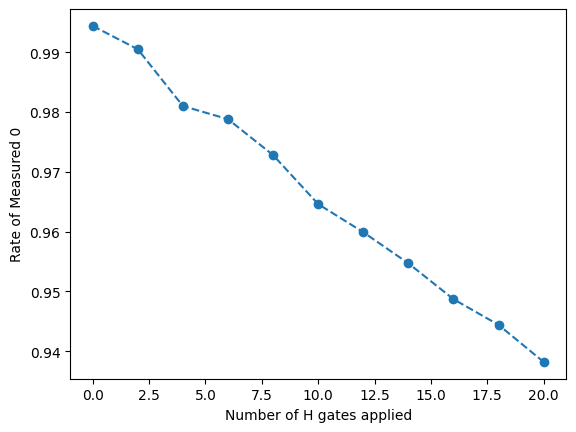

In [6]:
accuracies = []
for output in all_data:
    log_counts = lqcirc.get_logical_output_counts(output)
    acc = log_counts['0'] / (log_counts['0'] + log_counts['1'])
    accuracies.append(acc)

h_gates_applied = range(0, (n_gates + 1) * increments, increments)
plt.plot(h_gates_applied, accuracies, 'o--')
plt.xlabel('Number of H gates applied')
plt.ylabel('Rate of Measured 0')
plt.show()

## Performing QEC cycles on demand

In [ ]:
lqcirc = LogicalCircuit(1, (7,1,3), steane_stabilizer_tableau)
lqcirc.encode(0, initial_states=[1])
lqcirc.perform_qec_cycle([0])
#lqcirc.draw('mpl')

## Constructing LogicalCircuits from physical QuantumCircuits

In [ ]:
# We can also construct a logical circuit from a physical qubit circuit, first by constructing a QuantumCircuit:
pqc = QuantumCircuit(2)
pqc.x(0)
# pqc.h(0)
# pqc.cx(0,1)
pqc.draw(output="mpl")

In [ ]:
# Then, we convert the QuantumCircuit to a LogicalCircuit:
lqc = LogicalCircuit.from_physical_circuit(pqc, (7,1,3), steane_stabilizer_tableau)
lqc.draw(output="mpl")